# Peak Sets -> Genes -> GO

Copy of noteboook in 20200416_cicero. Go from peak sets to gene sets through coaccessible links, and then to GO ontology analysis through g:profiler. Additionally show aggregate expression of linked genes from bulk data.

Inputs:
1. Peak sets in order.
2. Cicero output called on peaks in peak set.

In [ ]:
library(cicero)
library(Matrix)
library(ggplot2)
library(scales)
library(GenomicFeatures)
library(reshape2)
library(rtracklayer)
library(patchwork)
library(gprofiler2)
library(viridis)

In [2]:
gz = "../../analysis/20200416_cicero/out/20200529_k200_maxelem500_20200520_n68916_overlap_smallpeaks/coaccess.gt0.1.tsv.gz"
high_conns = read.table(gz, header=F, sep='\t')
colnames(high_conns) = c("Peak1", "Peak2", "coaccess")
high_conns$distance = abs(as.integer(lapply(strsplit(as.character(high_conns$Peak1), "_"), "[[", 2)) - as.integer(lapply(strsplit(as.character(high_conns$Peak2), "_"), "[[", 2)))
min(high_conns$coaccess)
dim(high_conns)
head(high_conns)

[1] 0.1

[1] 37974486        4

,Peak1,Peak2,coaccess,distance
,<fct>,<fct>,<dbl>,<int>
1,chr10_100000215_100000415,chr10_99749761_99750006,0.3785478,250454
2,chr10_100000215_100000415,chr10_99768506_99768737,0.2277071,231709
3,chr10_100000215_100000415,chr10_99768737_99768990,0.3100303,231478
4,chr10_100000215_100000415,chr10_99775997_99776219,0.1733493,224218
5,chr10_100000215_100000415,chr10_99776219_99776455,0.1706237,223996
6,chr10_100000215_100000415,chr10_99776645_99776893,0.2274022,223570


In [3]:
# filter by score 
high_conns = high_conns[high_conns$coaccess>0.2, ]

# filter by distance
# high_conns = high_conns[high_conns$distance>500, ]

In [5]:
dim(high_conns)

[1] 17522420        4

## mRNA analysis

From Cachiarelli et al 2015

In [13]:
# load bulk RNA-seq data
fpkm = read.table("/users/surag/kundajelab/scATAC-reprog/resources/GSE62777/RNAseq.FPKM.tsv", sep='\t', header=T)
fpkm$gene_id = NULL
fpkm$locus=NULL
tpm = fpkm
tpm[,2:ncol(tpm)] = 1e6*t(t(tpm[,2:ncol(tpm)])/colSums(tpm[,2:ncol(tpm)]))

# removing genes with dup names
tpm = tpm[!duplicated(tpm$gene_short_name),]
rownames(tpm) = tpm$gene_short_name
tpm$gene_short_name = NULL

tpm["GAPDH",]

,hiF.T_P14,X2dd_DOX_plus,X5dd_DOX_plus,X8dd_DOX_plus,X10dd_DOX_plus_SSEA3_pos,X14dd_DOX_plus_SSEA3_pos,X20dd_DOX_plus_TRA_plus,X24dd_TRA_pos_DOX_plus,X24dd_TRA_pos_DOX_minus,hIPSC.T_P10
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GAPDH,7803.64,4963.505,3908.693,3839.776,3795.548,3364.503,3032.412,3790.955,5598.224,4731.256


## Prepare Promoters

In [12]:
gencode.basic.hg38 = import.gff(gzfile("../../../resources/GENCODE/gencode.v33.chr_patch_hapl_scaff.basic.annotation.gtf.gz"))
gencode.basic.hg38 = keepStandardChromosomes(gencode.basic.hg38, pruning.mode = "coarse")
gencode.basic.tx.hg38 = subset(subset(gencode.basic.hg38, gene_type=="protein_coding"), type=="transcript")
head(gencode.basic.tx.hg38, 2)
length(gencode.basic.tx.hg38)

Warning message in readGFF(filepath, version = version, filter = filter):
"connection is not positioned at the start of the file, rewinding it"


GRanges object with 2 ranges and 21 metadata columns:
      seqnames      ranges strand |   source       type     score     phase
         <Rle>   <IRanges>  <Rle> | <factor>   <factor> <numeric> <integer>
  [1]     chr1 65419-71585      + |   HAVANA transcript      <NA>      <NA>
  [2]     chr1 69055-70108      + |  ENSEMBL transcript      <NA>      <NA>
                gene_id      gene_type   gene_name       level     hgnc_id
            <character>    <character> <character> <character> <character>
  [1] ENSG00000186092.6 protein_coding       OR4F5           2  HGNC:14825
  [2] ENSG00000186092.6 protein_coding       OR4F5           3  HGNC:14825
               havana_gene     transcript_id transcript_type transcript_name
               <character>       <character>     <character>     <character>
  [1] OTTHUMG00000001094.4 ENST00000641515.2  protein_coding       OR4F5-202
  [2] OTTHUMG00000001094.4 ENST00000335137.4  protein_coding       OR4F5-201
      transcript_support_level    

[1] 58073

In [14]:
tss.hg38 = unique(resize(gencode.basic.tx.hg38, width=1, fix='start'))
head(tss.hg38, 2)

GRanges object with 2 ranges and 21 metadata columns:
      seqnames    ranges strand |   source       type     score     phase
         <Rle> <IRanges>  <Rle> | <factor>   <factor> <numeric> <integer>
  [1]     chr1     65419      + |   HAVANA transcript      <NA>      <NA>
  [2]     chr1     69055      + |  ENSEMBL transcript      <NA>      <NA>
                gene_id      gene_type   gene_name       level     hgnc_id
            <character>    <character> <character> <character> <character>
  [1] ENSG00000186092.6 protein_coding       OR4F5           2  HGNC:14825
  [2] ENSG00000186092.6 protein_coding       OR4F5           3  HGNC:14825
               havana_gene     transcript_id transcript_type transcript_name
               <character>       <character>     <character>     <character>
  [1] OTTHUMG00000001094.4 ENST00000641515.2  protein_coding       OR4F5-202
  [2] OTTHUMG00000001094.4 ENST00000335137.4  protein_coding       OR4F5-201
      transcript_support_level         tag

In [15]:
# for downstream analyses, allow co-accessibility to tss proximal enhancers
prom.hg38 = promoters(tss.hg38, upstream = 2000, downstream = 2000)
head(prom.hg38, 2)

GRanges object with 2 ranges and 21 metadata columns:
      seqnames      ranges strand |   source       type     score     phase
         <Rle>   <IRanges>  <Rle> | <factor>   <factor> <numeric> <integer>
  [1]     chr1 63419-67418      + |   HAVANA transcript      <NA>      <NA>
  [2]     chr1 67055-71054      + |  ENSEMBL transcript      <NA>      <NA>
                gene_id      gene_type   gene_name       level     hgnc_id
            <character>    <character> <character> <character> <character>
  [1] ENSG00000186092.6 protein_coding       OR4F5           2  HGNC:14825
  [2] ENSG00000186092.6 protein_coding       OR4F5           3  HGNC:14825
               havana_gene     transcript_id transcript_type transcript_name
               <character>       <character>     <character>     <character>
  [1] OTTHUMG00000001094.4 ENST00000641515.2  protein_coding       OR4F5-202
  [2] OTTHUMG00000001094.4 ENST00000335137.4  protein_coding       OR4F5-201
      transcript_support_level    

## Visualize

In [16]:
gene_anno <- data.frame(gencode.basic.hg38)
gene_anno = gene_anno[!is.na(gene_anno$exon_number), ]


# rename some columns to match requirements
gene_anno$chromosome <-  gene_anno$seqnames
gene_anno$gene <- gene_anno$gene_id
gene_anno$transcript <- gene_anno$transcript_name
gene_anno$symbol <- gene_anno$gene_name

In [26]:
dim(gene_anno)

ERROR: Error in eval(expr, envir, enclos): object 'gene_anno' not found


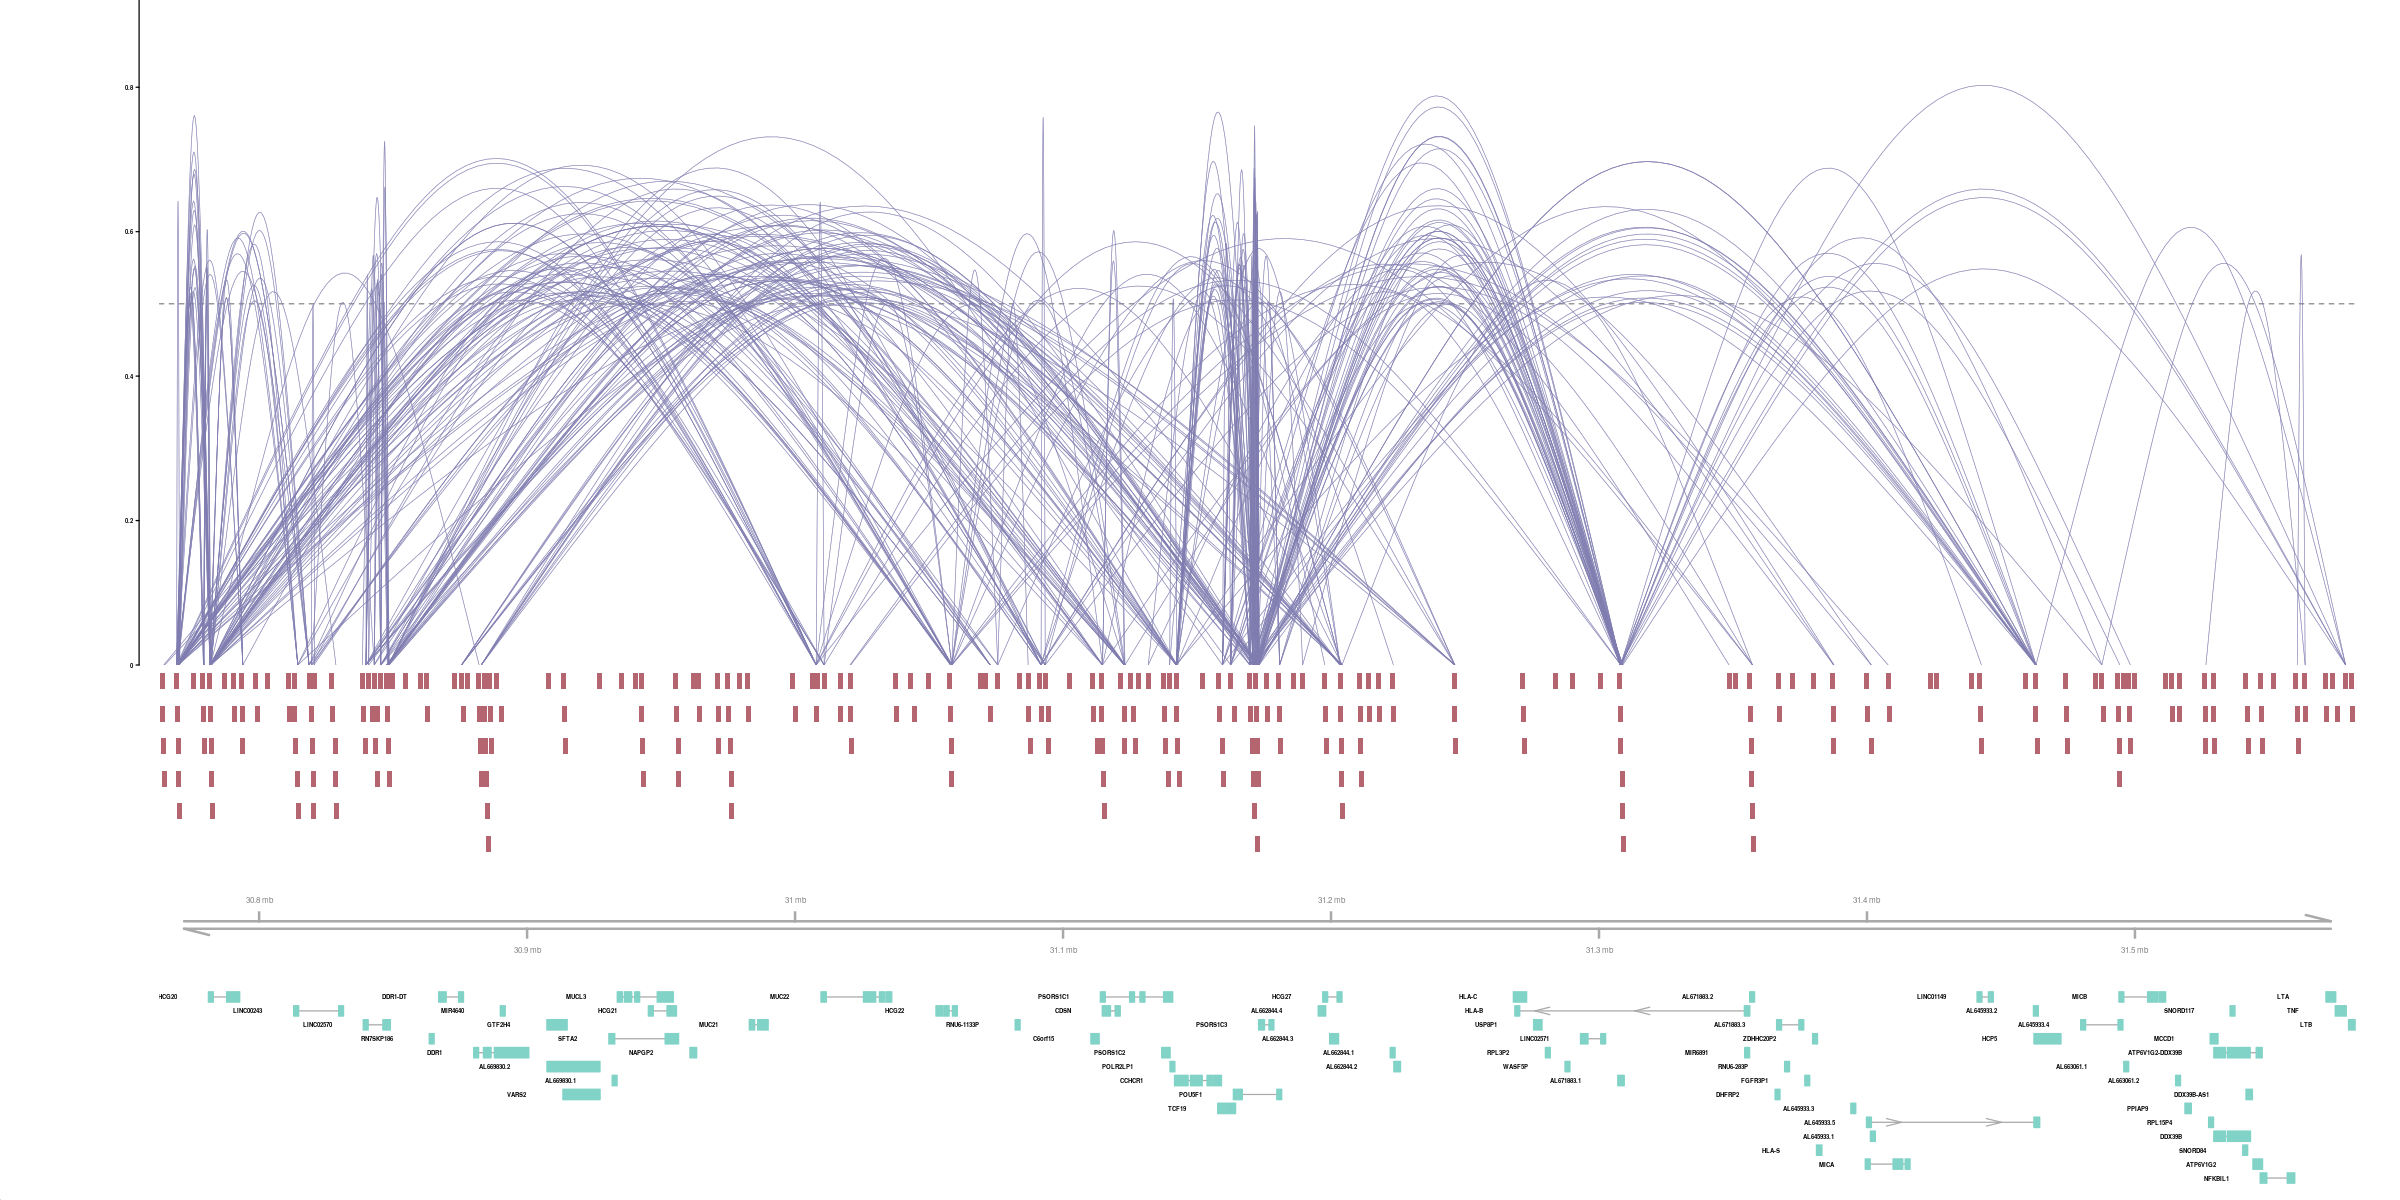

In [10]:
options(repr.plot.width = 20, repr.plot.height = 10)

# OCT4: "chr6", 30762659, 31582409
plot_connections(high_conns[high_conns$distance>1000,], "chr6", 30762659, 31582409,
#                  viewpoint = "chr2_209425462_209426064",
                 gene_model = gene_anno, 
                 coaccess_cutoff = .5, 
                 connection_width = .5, 
                 collapseTranscripts = "longest" )

## Links Gene Annotate

In [17]:
peaks_left = sub("_", "-", sub("_", ":", high_conns$Peak1))
peaks_right = sub("_", "-", sub("_", ":", high_conns$Peak2))
head(peaks_left)
head(peaks_right)

[1] "chr10:100000215-100000415" "chr10:100000215-100000415"
[3] "chr10:100000215-100000415" "chr10:100000215-100000415"
[5] "chr10:100000215-100000415" "chr10:100000215-100000415"

[1] "chr10:99749761-99750006" "chr10:99768506-99768737"
[3] "chr10:99768737-99768990" "chr10:99776645-99776893"
[5] "chr10:99784410-99784710" "chr10:99790689-99790941"

In [18]:
length(high_conns$coaccess)

[1] 17522420

In [23]:
# looks like each connection is entered twice
all(sort(peaks_left)==sort(peaks_right))

[1] TRUE

In [24]:
peaks_left_is_gene = seq(1,length(peaks_left)) %in% queryHits(findOverlaps(GRanges(peaks_left), prom.hg38))
peaks_right_is_gene = seq(1,length(peaks_right)) %in% queryHits(findOverlaps(GRanges(peaks_right), prom.hg38))
sum(peaks_left_is_gene)
sum(peaks_right_is_gene)

[1] 2317364

[1] 2317364

## Peak Sets

In [7]:
BASE_PATH = "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40/"
list.files(BASE_PATH)

[1] "all_peaks.bed" "idx1.bed"      "idx10.bed"     "idx11.bed"    
 [5] "idx12.bed"     "idx13.bed"     "idx14.bed"     "idx15.bed"    
 [9] "idx16.bed"     "idx17.bed"     "idx18.bed"     "idx19.bed"    
[13] "idx2.bed"      "idx20.bed"     "idx21.bed"     "idx22.bed"    
[17] "idx23.bed"     "idx24.bed"     "idx25.bed"     "idx26.bed"    
[21] "idx27.bed"     "idx28.bed"     "idx29.bed"     "idx3.bed"     
[25] "idx30.bed"     "idx31.bed"     "idx32.bed"     "idx33.bed"    
[29] "idx34.bed"     "idx35.bed"     "idx36.bed"     "idx37.bed"    
[33] "idx38.bed"     "idx39.bed"     "idx4.bed"      "idx40.bed"    
[37] "idx5.bed"      "idx6.bed"      "idx7.bed"      "idx8.bed"     
[41] "idx9.bed"      "README.md"     "width_200bp"

In [86]:
PEAK_SET_BEDS = list.files(BASE_PATH, 
                           full.names=T,
                          pattern="*idx[0-9]*")
PEAK_SET_NAMES = sub(".bed", "", list.files(BASE_PATH, 
                          pattern="*idx[0-9]*"))
length(PEAK_SET_BEDS)
length(PEAK_SET_NAMES)

[1] 40

[1] 40

In [87]:
# alphanumeric sort 
PEAK_SET_BEDS = PEAK_SET_BEDS[order(nchar(PEAK_SET_BEDS), PEAK_SET_BEDS)]
PEAK_SET_NAMES = PEAK_SET_NAMES[order(nchar(PEAK_SET_NAMES), PEAK_SET_NAMES)]

In [88]:
PEAK_SET_BEDS
PEAK_SET_NAMES

[1] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx1.bed" 
 [2] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx2.bed" 
 [3] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx3.bed" 
 [4] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx4.bed" 
 [5] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx5.bed" 
 [6] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx6.bed" 
 [7] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx7.bed" 
 [8] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx8.bed" 
 [9] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx9.bed" 
[10] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx10.bed"
[11] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx11.bed"
[12] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx12.bed"
[13] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx13.bed"
[14] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx14.bed"
[15] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx15.bed"
[16] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx16.bed"
[17] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx17.bed"
[18] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx18.bed"
[19] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx19.bed"
[20] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx20.bed"
[21] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx21.bed"
[22] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx22.bed"
[23] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx23.bed"
[24] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx24.bed"
[25] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx25.bed"
[26] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx26.bed"
[27] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx27.bed"
[28] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx28.bed"
[29] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx29.bed"
[30] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx30.bed"
[31] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx31.bed"
[32] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx32.bed"
[33] "../../analysis/20200307_fin

[1] "idx1"  "idx2"  "idx3"  "idx4"  "idx5"  "idx6"  "idx7"  "idx8"  "idx9" 
[10] "idx10" "idx11" "idx12" "idx13" "idx14" "idx15" "idx16" "idx17" "idx18"
[19] "idx19" "idx20" "idx21" "idx22" "idx23" "idx24" "idx25" "idx26" "idx27"
[28] "idx28" "idx29" "idx30" "idx31" "idx32" "idx33" "idx34" "idx35" "idx36"
[37] "idx37" "idx38" "idx39" "idx40"

## Link to Genes

In [25]:
peak_sets = list()
gene_links = list()
gene_links_table = list()

In [26]:
for (i in seq(length(PEAK_SET_BEDS))) {
    peak_set = read.table(PEAK_SET_BEDS[i])
    colnames(peak_set) = c("chr", "start", "end")    
    peak_set = paste(paste(peak_set$chr, peak_set$start, sep=":"), peak_set$end, sep='-')
    peak_sets[[i]] = peak_set
    
    # strict overlap assuming peak sets and coaccs links have same underlying regions
    peaks_left_overlaps_peak_set = peaks_left %in% peak_set
    peaks_right_overlaps_peak_set = peaks_right %in% peak_set

    # sum(peaks_left_overlaps_peak_set)
    # sum(peaks_right_overlaps_peak_set)
    
    # find enhancer/non-promoter -> gene links such that enhancer belongs to set
    # can look from left to right only since each link is repeated twice 
    enhancer_to_gene_link = (peaks_left_overlaps_peak_set&(!peaks_left_is_gene)&(peaks_right_is_gene)) #&(high_conns$distance>10000))
    e2g_overlaps = findOverlaps(GRanges(peaks_right[enhancer_to_gene_link]), prom.hg38)
    
    e2g_enhs = peaks_left[enhancer_to_gene_link][queryHits(e2g_overlaps)] # these are the enhancers that link to gene
    # e2g_genes = prom.hg38[subjectHits(e2g_overlaps)]$gene_name
    e2g_transcripts = prom.hg38[subjectHits(e2g_overlaps)]$transcript_name
    
    # e2g_uniq = unique(data.frame(e=e2g_enhs, g=e2g_genes)) # uniquify e-g link
    e2gt_uniq = unique(data.frame(e=e2g_enhs, gtx=e2g_transcripts)) # uniquify e-g:tx link

    # look at 5kb bins that are linked to gene, instead of number of enhancers (which can be nearby)
    # note that coaccess links are within choromosomes only, so do not need to identify chr in bin
    #b2g_uniq = unique(data.frame(b=as.integer(start(GRanges(e2g_uniq$e))/5000),  # break into 5kb bins
    #                             g=e2g_uniq$g)) # uniquify bin-gene link
    b2gt_uniq = unique(data.frame(b=as.integer(start(GRanges(e2gt_uniq$e))/5000),  # break into 5kb bins
                                 gtx=e2gt_uniq$g)) # uniquify bin-g:tx link
    
    gene_links[[i]] = e2gt_uniq
    gene_links_table[[i]] = rev(sort(table(b2gt_uniq$gtx))) # transcripts with number of regions linked
}

## Gene Expression per Peak Set

In [27]:
# number of genes for which average expression is plotted per peak set
TOP_GENES_PER_PEAK_SET = 100

In [28]:
gene_plots = list()

In [29]:
# from a list of transcript with their counts, extracts gene names for transcripts
# with at least min_count counts and uniquifies
transcript_table_to_gene_list <- function(transcript_table, min_count=2) {
    unique(sub("-2[0-9]+", "", names(transcript_table[transcript_table>=min_count])))
}

In [30]:
plot_genes_agg <- function(gene_log_tpm, gene_list, plot_name="", plot_each=F, znorm=F, max_y=10) {
    
    if (znorm==T) {
        plot = ggplot(melt(t(scale(t(gene_log_tpm[rownames(gene_log_tpm) %in% gene_list, ])))), aes(x=Var2, y=value))
    }
    else {
        plot = ggplot(melt(as.matrix(gene_log_tpm[rownames(gene_log_tpm) %in%  gene_list, ])), aes(x=Var2, y=value))
    }
    
    plot = plot + stat_boxplot()
    
    if (plot_each ==TRUE) {
        plot = plot + geom_line(aes(group=Var1),size=0.1) + geom_point() 
    }
    
    plot = plot + ggtitle(plot_name) +
    theme_classic() +
    theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
#       axis.line=element_blank(),
      axis.text.x = element_text(angle = -45, hjust=0),
#       axis.text.y=element_blank(),
#       axis.ticks=element_blank(),
      legend.title=element_text(size=10), 
      legend.text=element_text(size=9),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5)) + 
    xlab("")
    
    if (znorm==TRUE) {
        plot = plot + ylab("Z-norm log TPM")
    }
    else {
        plot = plot + ylab("log2 TPM") + coord_cartesian(ylim=c(0,max_y))
    }
    
    
    plot
}

In [31]:
for (i in seq(length(PEAK_SET_BEDS))) {
    # remove transcript name from gene
    # assumes gene lists are tables sorted in decreasing importance
    gene_set_to_plot = transcript_table_to_gene_list(gene_links_table[[i]], min_count=2)
    
    # filter to those that have >1 TPM at any time point
    gene_set_to_plot = gene_set_to_plot[gene_set_to_plot %in% rownames(tpm)]
    gene_set_to_plot = gene_set_to_plot[rowMaxs(as.matrix(tpm[gene_set_to_plot, ]))>1]

    # choose top
    gene_set_to_plot = gene_set_to_plot[1:TOP_GENES_PER_PEAK_SET]

    gene_plots[[i]] <- plot_genes_agg(log2(1+tpm), gene_set_to_plot, PEAK_SET_NAMES[i])
}


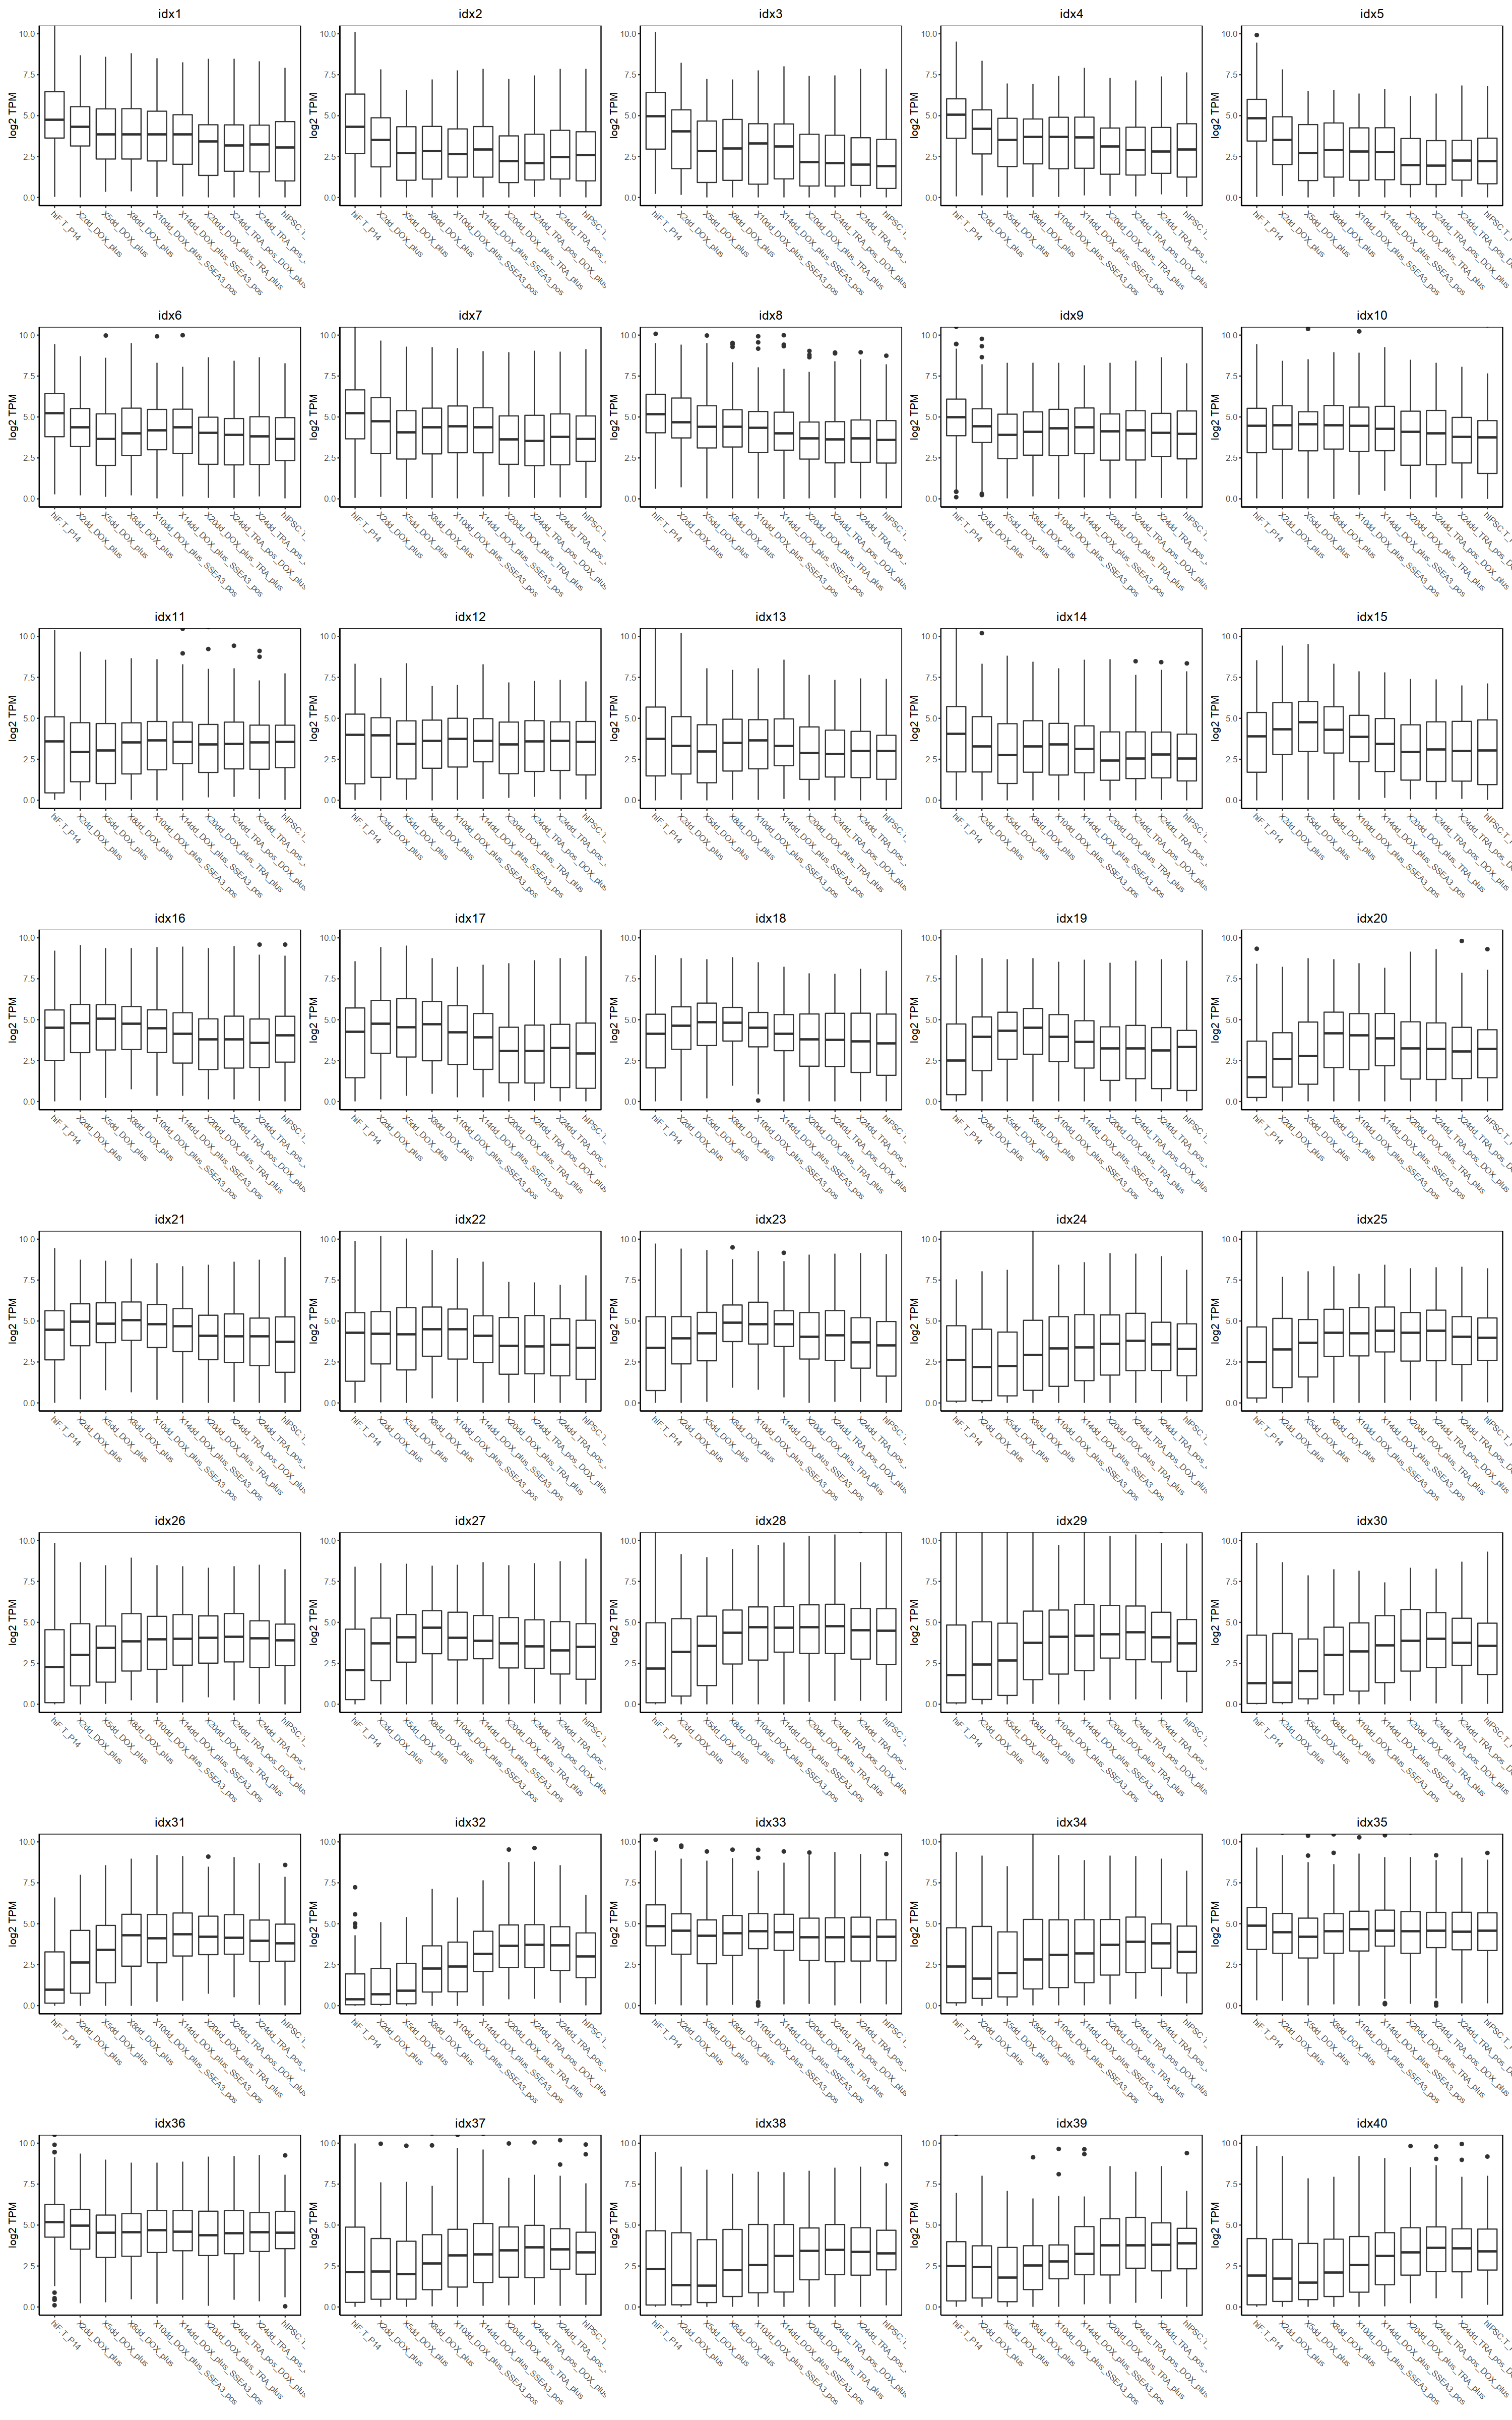

In [32]:
options(repr.plot.width = 25, repr.plot.height = 40)

wrap_plots(gene_plots, ncol = 5) 

## g:Profiler

In [33]:
# maximum number of genes per list
MAX_GENES_GPROF = 5000

In [34]:
# assumes gene_table is sorted in decreasing importance
get_gprof_gost_res <- function(gene_table) {
    genes_ordered = unique(sub("-2[0-9]+", "", names(gene_table[gene_table>=2])))
    genes_ordered = genes_ordered[1:min(length(genes_ordered), MAX_GENES_GPROF)]
    
    gostres = gost(genes_ordered, 
              organism="hsapiens",
              significant=F, # return all
              ordered_query=T)
    
    # compute enrichment (intersection/list_length)/(total_terms/total_genes)
    gostres$result$enrichment = (gostres$result$intersection_size/gostres$result$query_size)/(gostres$result$term_size/gostres$result$effective_domain_size)
    
    gostres
}

In [35]:
gprof_res = mclapply(gene_links_table,
                     get_gprof_gost_res,
                     mc.cores=10)

In [848]:
filtered = gprof_res[[3]]$result
filtered = filtered[filtered$significant==TRUE, ]
filtered = filtered[filtered$source=="GO:BP", c(4,5,6,12, 10,11,3, 15)]
dim(filtered)
head(filtered[rev(order(filtered$enrichment)), ], 5)

[1] 319   8

,term_size,query_size,intersection_size,effective_domain_size,source,term_name,p_value,enrichment
,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>
913,56,2,2,17906,GO:BP,negative regulation of lymphocyte differentiation,0.0228732839,319.75000
762,13,71,4,17906,GO:BP,midgut development,0.0003760155,77.59913
954,122,8,3,17906,GO:BP,regulation of myeloid leukocyte differentiation,0.0401325008,55.03893
886,8,292,4,17906,GO:BP,mesenchymal-epithelial cell signaling,0.0109669494,30.66096
890,53,85,5,17906,GO:BP,mesenchyme morphogenesis,0.0122247729,19.87347


## Analyse a GO Term

In [631]:
library(org.Hs.eg.db)
library(GO.db)

In [926]:
filtered = gprof_res[[38]]$result[grep("copper ion", gprof_res[[38]]$result$term_name), ]
filtered = filtered[filtered$significant==TRUE, ]
filtered

,query,significant,p_value,term_size,query_size,intersection_size,precision,recall,term_id,source,term_name,effective_domain_size,source_order,parents,enrichment
,<chr>,<lgl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<list>,<dbl>
1791,query_1,TRUE,2.311291e-06,14,151,6,0.0397351,0.4285714,GO:1990169,GO:BP,stress response to copper ion,17906,29137,"GO:0046688, GO:0097501",50.82119
1792,query_1,TRUE,2.311291e-06,14,151,6,0.0397351,0.4285714,GO:0010273,GO:BP,detoxification of copper ion,17906,4576,"GO:0061687, GO:1990169",50.82119
1801,query_1,TRUE,1.262626e-04,25,151,6,0.0397351,0.2400000,GO:0071280,GO:BP,cellular response to copper ion,17906,19670,"GO:0046688, GO:0071248",28.45987
1811,query_1,TRUE,2.465658e-03,40,151,6,0.0397351,0.1500000,GO:0046688,GO:BP,response to copper ion,17906,14590,GO:0010038,17.78742


In [927]:
genes_in_term = as.character(unlist(mget(get("GO:1990169", org.Hs.egGO2ALLEGS),org.Hs.egSYMBOL)))
length(genes_in_term)
head(genes_in_term)

[1] 15

[1] "ATP7A" "MT1A"  "MT1B"  "MT1E"  "MT1F"  "MT1G"

In [928]:
head(gprof_res[[38]]$meta$query_metadata$queries$query_1)

[1] "TRPM1"  "KLF13"  "TUBB2B" "TMC8"   "TMC6"   "SYNGR2"

In [929]:
ranked_gene_list = transcript_table_to_gene_list(gene_links_table[[38]], min_count=2)

In [930]:
length(ranked_gene_list)

[1] 4590

In [934]:
intersect_genes = intersect(ranked_gene_list[1:151], genes_in_term)
intersect_genes

[1] "MT3"  "MT2A" "MT1H" "MT1G" "MT1F" "MT1X"

In [ ]:
cur_links = (gene_links[[38]][grep("PIWIL2-201", gene_links[[3]]$gtx), ])
head(cur_links)

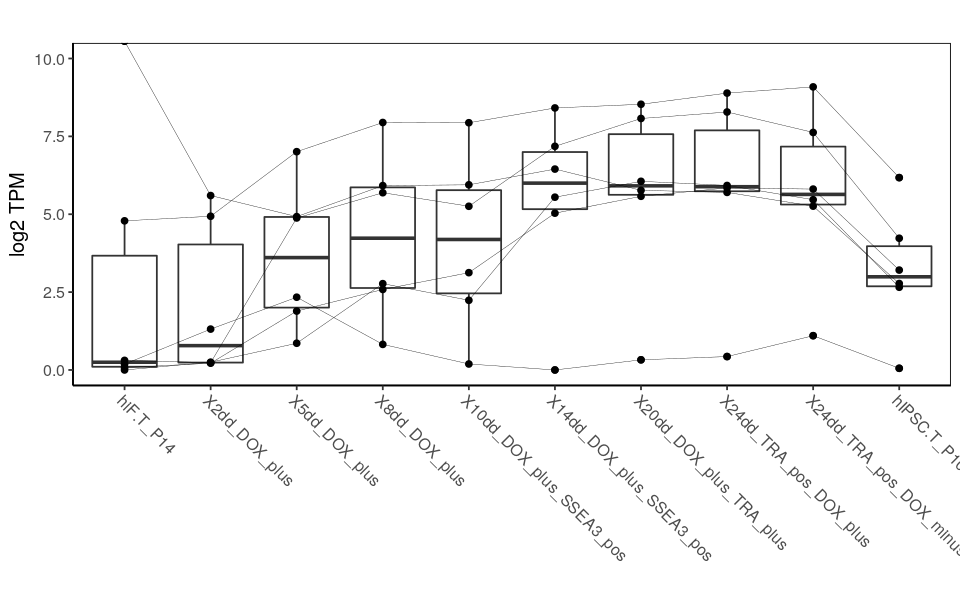

In [941]:
options(repr.plot.width = 8, repr.plot.height = 5)
plot_genes_agg(log2(1+tpm), intersect_genes,znorm=F, plot_each=T)

## Enrichment Matrices

In [94]:
MAX_LOG10_PVAL = 3 # restrict max p-value for clustering
SIG_PVAL = -log10(0.05)

make_term_peak_set_matrix <- function(term_list, sources) {
    # term_x_peak matrix
    txp_matrix = matrix(0, length(term_list), length(PEAK_SET_NAMES))
    row.names(txp_matrix) = term_list
    colnames(txp_matrix) = PEAK_SET_NAMES

    for (i in seq(length(PEAK_SET_NAMES))) { 
        filtered = gprof_res[[i]]$result
        filtered = filtered[as.character(filtered$term_name) %in% term_list, ]
        filtered = filtered[as.character(filtered$source) %in% sources, ] # need source since some terms are duplicated
        rownames(filtered) = filtered$term_name
        txp_matrix[,i] = -log10(filtered[rownames(txp_matrix), ]$p_value)
    }

    txp_matrix[is.na(txp_matrix)] = 0
    txp_matrix[txp_matrix>MAX_LOG10_PVAL] = MAX_LOG10_PVAL
    
    txp_matrix
}

make_melted_txp_matrix <- function(txp_matrix, peak_set_order) {
    # reorder terms, but specify peak order
    term_order = hclust(dist(txp_matrix, method = "euclidean"), method = "ward.D")$order

    txp_matrix_melted = melt(txp_matrix)
    txp_matrix_melted$symbol = ifelse(txp_matrix_melted$value>= SIG_PVAL, "*", "")

    txp_matrix_melted$Var2 = factor(txp_matrix_melted$Var2, 
                                     levels=levels(txp_matrix_melted$Var2)[peak_set_order])
    txp_matrix_melted$Var1 = factor(txp_matrix_melted$Var1, 
                                     levels=levels(txp_matrix_melted$Var1)[term_order])

    txp_matrix_melted
}

plot_melted_txp_matrix <- function(txp_matrix_melted) {
    plot <- ggplot(txp_matrix_melted) +
    geom_tile(aes(x=Var2, 
                  y=Var1, 
                  fill= value),
             colour="black",
             size=0.5) +
    scale_fill_gradient(low="white",
                          high="red",
                          limits=c(0,3),
                          oob=squish,
                          name="- Log P-value") +
    geom_text(aes(x=Var2, y=Var1, label=symbol), vjust = 0.75) + 
    scale_y_discrete(position = "right") +
    ylab("") + xlab("Peak Set") +
    theme_classic() +
    theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=15),
      axis.text.x = element_text(angle = -90, hjust=0, vjust=0.5),
      legend.title=element_text(size=10), 
      legend.text=element_text(size=9),
      axis.ticks=element_blank(),
      panel.border = element_rect(colour = "black", fill=NA, size=2),
      legend.position = "left") 
    
    plot
}


### GO:BP Matrix

In [103]:
# make a list of GO terms using cutoffs

ENRICH_CUTOFF = 2
TERM_SIZE_MAX = 100
TOP_BY_PVAL = 2 # add top K by pval per peak set
TOP_BY_ENRICH = 2 # add top K by enrichment per peak set
gobp_terms = c()

for (i in seq(length(PEAK_SET_NAMES))) {
    filtered = gprof_res[[i]]$result
    filtered = filtered[filtered$significant==TRUE, ]
    filtered = filtered[filtered$source=="GO:BP", c(4,5,6,12, 10,11,3, 15)]
    filtered = filtered[filtered$enrichment>ENRICH_CUTOFF, ]
    filtered = filtered[filtered$term_size<TERM_SIZE_MAX, ]
    filtered = filtered[unique(order(filtered$p_value)[1:TOP_BY_PVAL],
                              rev(order(filtered$enrichment))[1:TOP_BY_ENRICH]), ]
    
    gobp_terms = unique(c(gobp_terms, filtered$term_name))
}

# gobp_terms = names(table(gobp_terms)[table(gobp_terms)<=MAX_APPEARANCES])
gobp_terms = gobp_terms[!is.na(gobp_terms)]
length(gobp_terms)

[1] 46

In [104]:
gobp_terms[grep("stem", gobp_terms)]
gobp_terms[grep("fibro", gobp_terms)]
gobp_terms[grep("apop", gobp_terms)]
gobp_terms[grep("water", gobp_terms)]

character(0)

[1] "regulation of fibroblast growth factor receptor signaling pathway"
[2] "fibroblast migration"

character(0)

character(0)

In [105]:
gobp_matrix = make_term_peak_set_matrix(gobp_terms, sources=c("GO:BP"))
# PEAK_SET_ORDER = rev(hclust(dist(t(gobp_matrix), method = "euclidean"), method = "ward.D")$order) # use for REAC plot also
PEAK_SET_ORDER = seq(1, ncol(gobp_matrix)) # no reorder
gobp_matrix_melted = make_melted_txp_matrix(gobp_matrix, PEAK_SET_ORDER)

In [106]:
# remove idx from peak set 
gobp_matrix_melted$Var2 = factor(sub("idx", "", gobp_matrix_melted$Var2),
                                 sub("idx", "", levels(gobp_matrix_melted$Var2)))

In [107]:
gobp_plot = plot_melted_txp_matrix(gobp_matrix_melted)

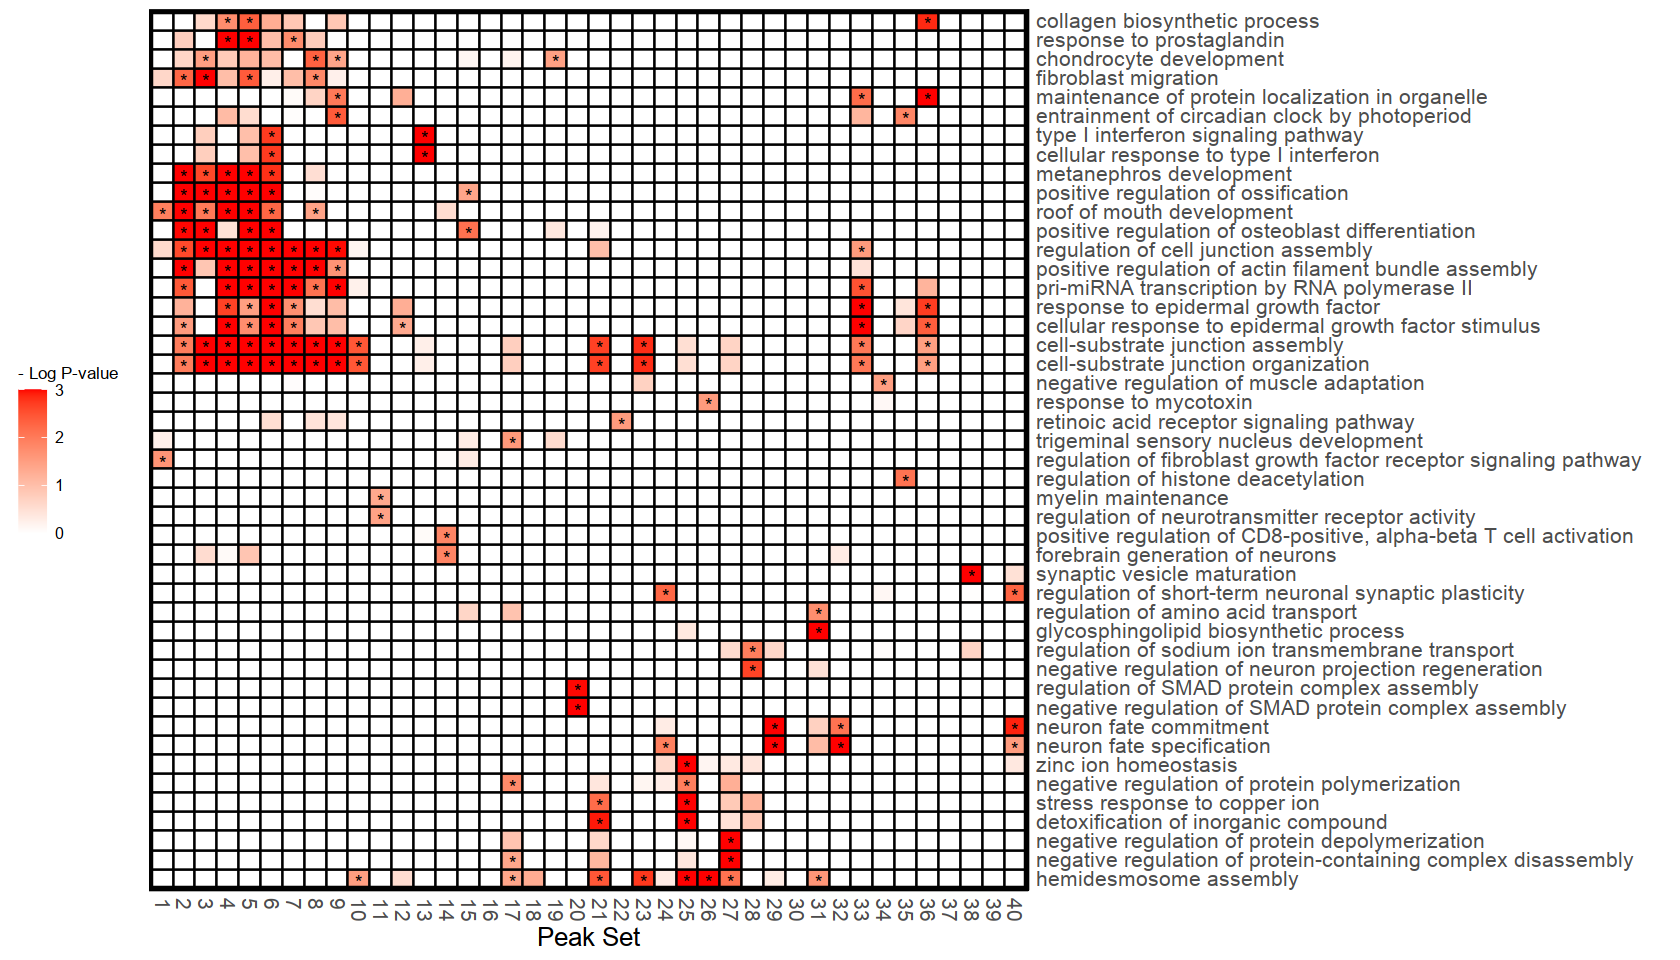

In [110]:
options(repr.plot.width = 14, repr.plot.height = 8)

gobp_plot

In [109]:
saveRDS(gobp_plot, file=sprintf("./subfigs/%s_go_terms.rds",
                                format(Sys.Date(), "%Y%m%d")))

### REAC Matrix

In [59]:
# make a list of REAC terms using cutoffs

ENRICH_CUTOFF = 2
TERM_SIZE_MAX = 200
TOP_BY_PVAL = 20 # add top K by pval per peak set
TOP_BY_ENRICH = 20 # add top K by enrichment per peak set
reac_terms = c()

for (i in seq(length(PEAK_SET_NAMES))) {
    filtered = gprof_res[[i]]$result
    filtered = filtered[filtered$significant==TRUE, ]
    filtered = filtered[filtered$source=="REAC", c(4,5,6,12, 10,11,3, 15)]
    filtered = filtered[filtered$enrichment>ENRICH_CUTOFF, ]
    filtered = filtered[filtered$term_size<TERM_SIZE_MAX, ]
    filtered = filtered[unique(order(filtered$p_value)[1:TOP_BY_PVAL],
                              rev(order(filtered$enrichment))[1:TOP_BY_ENRICH]), ]
    
    reac_terms = unique(c(reac_terms, filtered$term_name))
}

reac_terms = reac_terms[!is.na(reac_terms)]
length(reac_terms)

[1] 63

In [60]:
gobp_terms[grep("pluri", reac_terms)]
gobp_terms[grep("fibro", reac_terms)]
gobp_terms[grep("apop", reac_terms)]
gobp_terms[grep("water", reac_terms)]

character(0)

character(0)

character(0)

character(0)

In [61]:
reac_matrix = make_term_peak_set_matrix(reac_terms, sources=c("REAC"))
reac_matrix_melted = make_melted_txp_matrix(reac_matrix, PEAK_SET_ORDER)
reac_plot = plot_melted_txp_matrix(reac_matrix_melted)

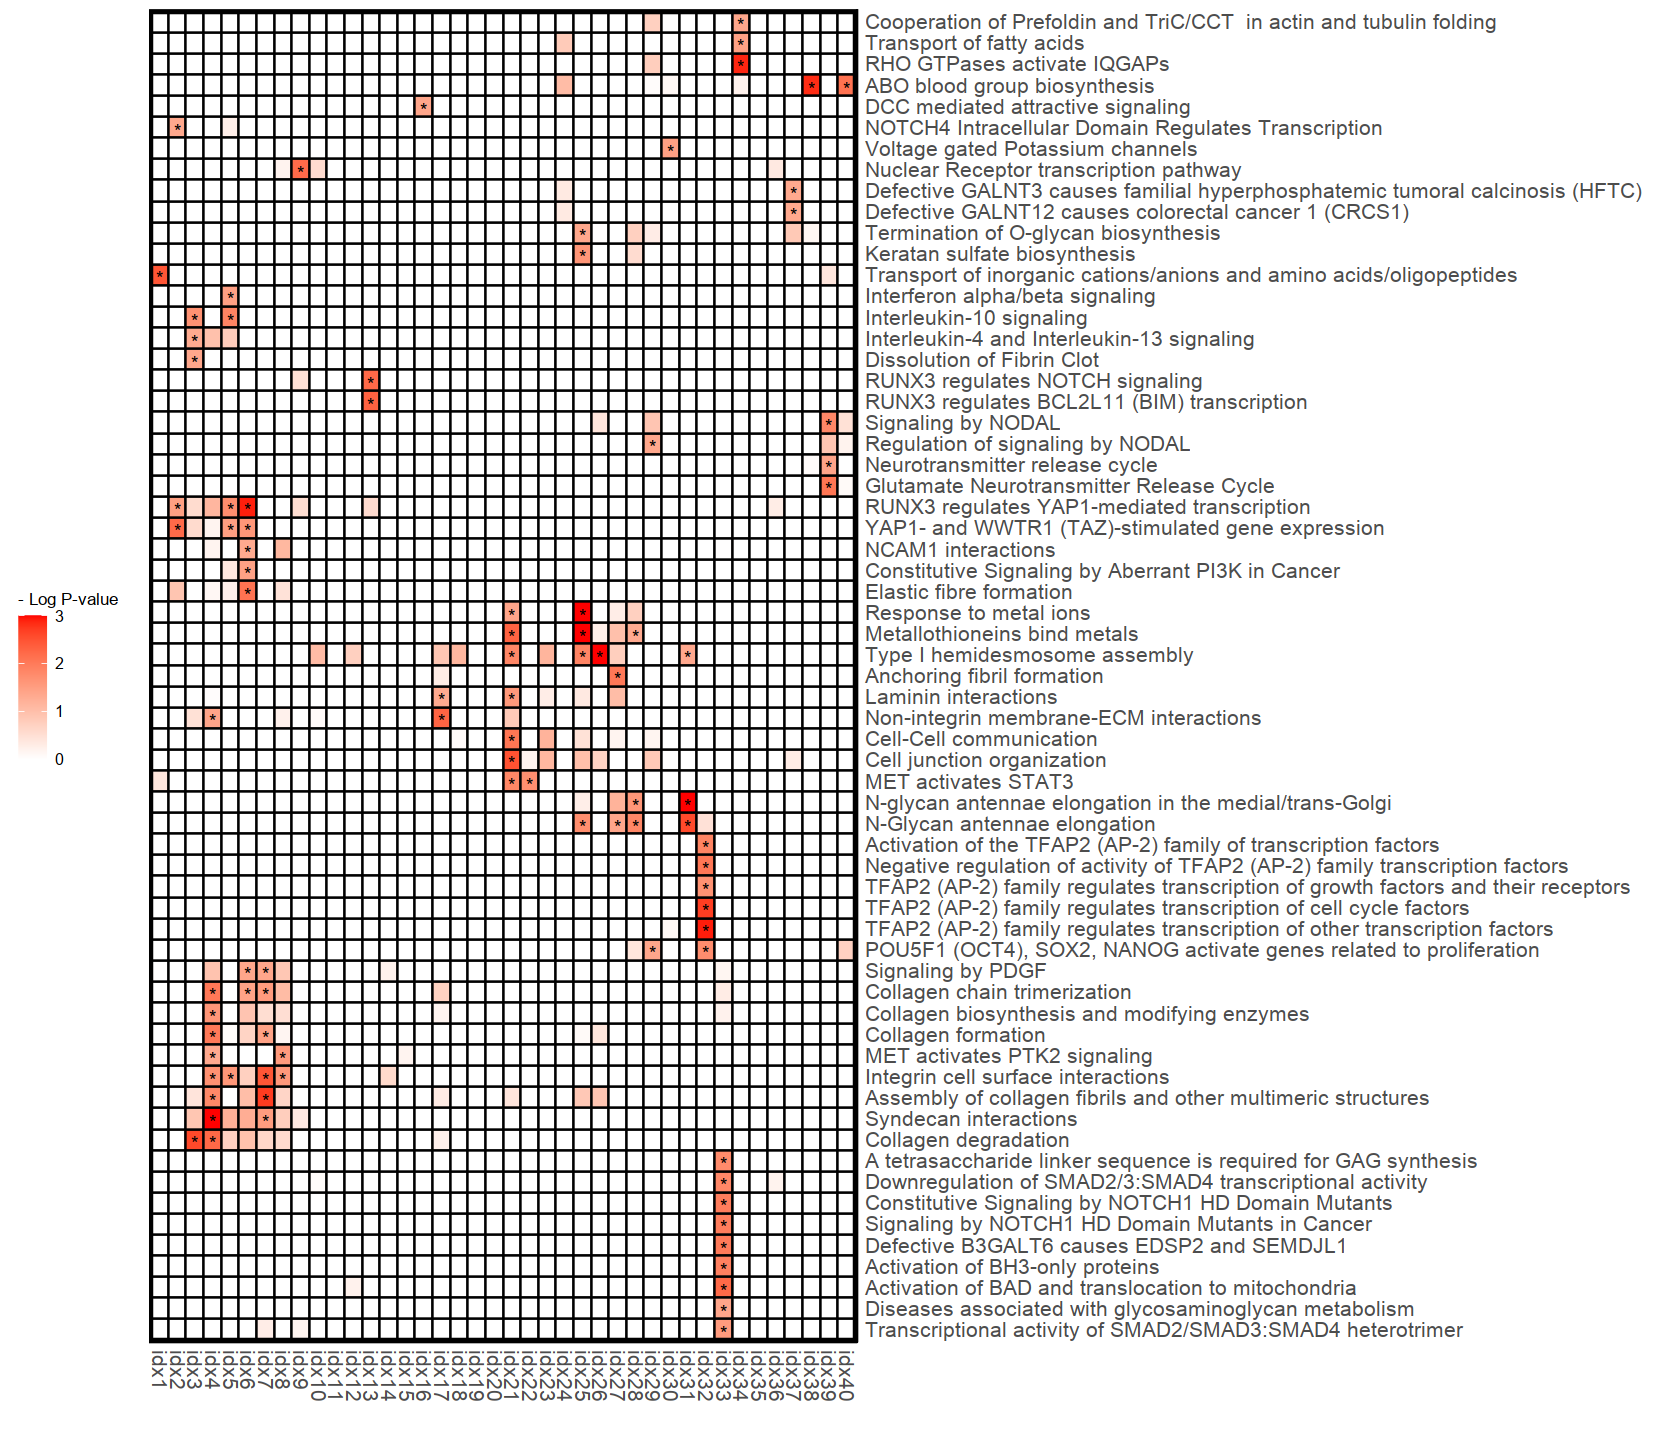

In [62]:
options(repr.plot.width = 14, repr.plot.height = 12)

reac_plot